In [7]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pytorch_wavelets import DWTForward, DWTInverse
import matplotlib.pyplot as plt

In [8]:
# Comprehensive Error Metrics and Evaluation Functions
import cv2
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(img1, img2):
    """Calculate SSIM between two images."""
    return ssim(img1, img2, data_range=1.0)

def calculate_psnr(img1, img2):
    """Calculate PSNR between two images."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))

def calculate_gradient_magnitude(img):
    """Calculate gradient magnitude using Sobel operators."""
    # Convert to uint8 for OpenCV
    img_uint8 = (img * 255).astype(np.uint8)
    grad_x = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    return np.sqrt(grad_x**2 + grad_y**2) / 255.0

def calculate_edge_preservation(fused, ct, mri):
    """Calculate edge preservation metric."""
    # Calculate gradients
    grad_fused = calculate_gradient_magnitude(fused)
    grad_ct = calculate_gradient_magnitude(ct)
    grad_mri = calculate_gradient_magnitude(mri)
    
    # Maximum gradient from sources
    grad_max = np.maximum(grad_ct, grad_mri)
    
    # Edge preservation as correlation
    correlation = np.corrcoef(grad_fused.flatten(), grad_max.flatten())[0, 1]
    return correlation if not np.isnan(correlation) else 0.0

def calculate_entropy(img):
    """Calculate image entropy."""
    # Convert to 8-bit for histogram
    img_uint8 = (img * 255).astype(np.uint8)
    hist, _ = np.histogram(img_uint8, bins=256, range=(0, 256))
    hist = hist / hist.sum()  # Normalize
    hist = hist[hist > 0]  # Remove zeros
    return -np.sum(hist * np.log2(hist))

def calculate_mutual_information(img1, img2):
    """Calculate mutual information between two images."""
    # Convert to 8-bit
    img1_uint8 = (img1 * 255).astype(np.uint8)
    img2_uint8 = (img2 * 255).astype(np.uint8)
    
    # Joint histogram
    hist_2d, _, _ = np.histogram2d(img1_uint8.flatten(), img2_uint8.flatten(), bins=256)
    
    # Normalize
    hist_2d = hist_2d / hist_2d.sum()
    
    # Marginal histograms
    hist_1 = hist_2d.sum(axis=1)
    hist_2 = hist_2d.sum(axis=0)
    
    # Calculate MI
    mi = 0.0
    for i in range(256):
        for j in range(256):
            if hist_2d[i, j] > 0 and hist_1[i] > 0 and hist_2[j] > 0:
                mi += hist_2d[i, j] * np.log2(hist_2d[i, j] / (hist_1[i] * hist_2[j]))
    
    return mi

def evaluate_fusion_quality(fused, ct, mri):
    """Comprehensive evaluation of fusion quality."""
    if fused is None:
        return {}
    
    metrics = {}
    
    # SSIM with both source images
    metrics['SSIM_CT'] = calculate_ssim(fused, ct)
    metrics['SSIM_MRI'] = calculate_ssim(fused, mri)
    metrics['SSIM_Avg'] = (metrics['SSIM_CT'] + metrics['SSIM_MRI']) / 2
    
    # PSNR with both source images
    metrics['PSNR_CT'] = calculate_psnr(fused, ct)
    metrics['PSNR_MRI'] = calculate_psnr(fused, mri)
    metrics['PSNR_Avg'] = (metrics['PSNR_CT'] + metrics['PSNR_MRI']) / 2
    
    # Edge preservation
    metrics['Edge_Preservation'] = calculate_edge_preservation(fused, ct, mri)
    
    # Entropy (information content)
    metrics['Entropy'] = calculate_entropy(fused)
    
    # Mutual information with sources
    metrics['MI_CT'] = calculate_mutual_information(fused, ct)
    metrics['MI_MRI'] = calculate_mutual_information(fused, mri)
    metrics['MI_Avg'] = (metrics['MI_CT'] + metrics['MI_MRI']) / 2
    
    return metrics

In [9]:
class CTMRIDataset(Dataset):
    def __init__(self, ct_dir, mri_dir, transform=None):
        self.ct_files = sorted([os.path.join(ct_dir, f) for f in os.listdir(ct_dir) if f.endswith('.png')])
        self.mri_files = sorted([os.path.join(mri_dir, f) for f in os.listdir(mri_dir) if f.endswith('.png')])
        self.transform = transform
        
        # Ensure we have matching pairs by taking the minimum length
        min_len = min(len(self.ct_files), len(self.mri_files))
        self.ct_files = self.ct_files[:min_len]
        self.mri_files = self.mri_files[:min_len]
        
        print(f"Dataset initialized with {len(self.ct_files)} CT files and {len(self.mri_files)} MRI files")

    def __len__(self):
        return len(self.ct_files)

    def __getitem__(self, idx):
        ct = cv2.imread(self.ct_files[idx], cv2.IMREAD_GRAYSCALE)
        mri = cv2.imread(self.mri_files[idx], cv2.IMREAD_GRAYSCALE)
        
        # Resize images to ensure consistent dimensions
        ct = cv2.resize(ct, (256, 256))
        mri = cv2.resize(mri, (256, 256))
        
        ct = ct.astype(np.float32)/255.
        mri = mri.astype(np.float32)/255.

        # Add channel dim
        ct = np.expand_dims(ct, axis=0)
        mri = np.expand_dims(mri, axis=0)

        if self.transform:
            ct = self.transform(ct)
            mri = self.transform(mri)

        return torch.tensor(ct), torch.tensor(mri)

# Example usage
# dataset = CTMRIDataset('data/ct','data/mri')
# loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [10]:
class WaveletFusionNetSpatial(nn.Module):
    def __init__(self, wave='haar'):
        super().__init__()
        self.dwt = DWTForward(J=1, wave=wave)
        self.idwt = DWTInverse(wave=wave)
        self.mask_net = nn.Sequential(
            nn.Conv2d(2,16,3,padding=1), nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,4,3,padding=1), nn.Sigmoid()
        )

    def forward(self, ct, mr):
        # --- Ensure 4D ---
        if ct.dim() == 3: ct = ct.unsqueeze(0)
        if mr.dim() == 3: mr = mr.unsqueeze(0)

        # --- DWT decomposition ---
        ct_low, ct_high = self.dwt(ct)
        mr_low, mr_high = self.dwt(mr)

        # --- Split high-frequency channels ---
        # ct_high[0] has shape [batch, channels, 3, H, W] - need to properly index
        ct_lh, ct_hl, ct_hh = ct_high[0][:,:,0:1,:,:], ct_high[0][:,:,1:2,:,:], ct_high[0][:,:,2:3,:,:]
        mr_lh, mr_hl, mr_hh = mr_high[0][:,:,0:1,:,:], mr_high[0][:,:,1:2,:,:], mr_high[0][:,:,2:3,:,:]
        
        # Squeeze the extra dimension to get [batch, channels, H, W]
        ct_lh, ct_hl, ct_hh = ct_lh.squeeze(2), ct_hl.squeeze(2), ct_hh.squeeze(2)
        mr_lh, mr_hl, mr_hh = mr_lh.squeeze(2), mr_hl.squeeze(2), mr_hh.squeeze(2)

        # --- Low-frequency mask input ---
        low_stack = torch.cat([ct_low, mr_low], dim=1)
        # Keep mask computation at low-frequency resolution
        masks_low = self.mask_net(low_stack)
        mL, mLH_small, mHL_small, mHH_small = masks_low[:,0:1], masks_low[:,1:2], masks_low[:,2:3], masks_low[:,3:4]
        
        # Resize high-frequency masks to match high-frequency component dimensions
        high_freq_size = (ct_lh.shape[2], ct_lh.shape[3])
        mLH = F.interpolate(mLH_small, size=high_freq_size, mode='bilinear', align_corners=False)
        mHL = F.interpolate(mHL_small, size=high_freq_size, mode='bilinear', align_corners=False)
        mHH = F.interpolate(mHH_small, size=high_freq_size, mode='bilinear', align_corners=False)

        # --- Fuse low-frequency ---
        # Keep the low frequency at its original size (half of input size) for inverse DWT
        fused_low = mL*ct_low + (1-mL)*mr_low

        # --- Fuse high-frequency ---
        fused_lh = mLH*ct_lh + (1-mLH)*mr_lh
        fused_hl = mHL*ct_hl + (1-mHL)*mr_hl
        fused_hh = mHH*ct_hh + (1-mHH)*mr_hh
        
        # Stack them back to the original format for inverse DWT
        fused_high = torch.stack([fused_lh, fused_hl, fused_hh], dim=2)

        # --- Inverse DWT ---
        fused = self.idwt((fused_low, [fused_high]))
        return fused

In [11]:
class SSIM(nn.Module):
    """SSIM Loss Module"""
    def __init__(self, window_size=11, C1=0.01**2, C2=0.03**2):
        super().__init__()
        self.window_size = window_size
        self.C1 = C1
        self.C2 = C2
        
        # Create Gaussian window
        self.register_buffer('window', self._create_window(window_size))
    
    def _gaussian(self, window_size, sigma):
        gauss = torch.Tensor([np.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
        return gauss/gauss.sum()
    
    def _create_window(self, window_size, channel=1):
        _1D_window = self._gaussian(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window
    
    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()
        
        # Always create window on the same device and dtype as input
        window = self._create_window(self.window_size, channel).to(img1.device).type(img1.dtype)
        
        return self._ssim(img1, img2, window, self.window_size, channel)
    
    def _ssim(self, img1, img2, window, window_size, channel):
        mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
        mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding = window_size//2, groups = channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding = window_size//2, groups = channel) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding = window_size//2, groups = channel) - mu1_mu2

        ssim_map = ((2 * mu1_mu2 + self.C1) * (2 * sigma12 + self.C2)) / ((mu1_sq + mu2_sq + self.C1) * (sigma1_sq + sigma2_sq + self.C2))

        return ssim_map.mean()

class GradientLoss(nn.Module):
    """Gradient Loss for Edge Preservation"""
    def __init__(self):
        super().__init__()
    
    def forward(self, fused, ct, mr):
        # Sobel filters
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(fused.device)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(fused.device)
        
        # Calculate gradients
        fused_grad_x = F.conv2d(fused, sobel_x, padding=1)
        fused_grad_y = F.conv2d(fused, sobel_y, padding=1)
        fused_grad = torch.sqrt(fused_grad_x**2 + fused_grad_y**2 + 1e-8)
        
        ct_grad_x = F.conv2d(ct, sobel_x, padding=1)
        ct_grad_y = F.conv2d(ct, sobel_y, padding=1)
        ct_grad = torch.sqrt(ct_grad_x**2 + ct_grad_y**2 + 1e-8)
        
        mr_grad_x = F.conv2d(mr, sobel_x, padding=1)
        mr_grad_y = F.conv2d(mr, sobel_y, padding=1)
        mr_grad = torch.sqrt(mr_grad_x**2 + mr_grad_y**2 + 1e-8)
        
        # Maximum gradient (edge information to preserve)
        max_grad = torch.maximum(ct_grad, mr_grad)
        
        # L1 loss between fused gradient and maximum source gradient
        return F.l1_loss(fused_grad, max_grad)

class EnhancedFusionLoss(nn.Module):
    def __init__(self, w_l1=1.0, w_ssim=1.0, w_grad=0.5):
        super().__init__()
        self.w_l1 = w_l1
        self.w_ssim = w_ssim
        self.w_grad = w_grad
        
        self.l1 = nn.L1Loss()
        self.ssim = SSIM()
        self.grad_loss = GradientLoss()
    
    def forward(self, fused, ct, mr):
        # L1 reconstruction loss
        l1_ct = self.l1(fused, ct)
        l1_mr = self.l1(fused, mr)
        l1_total = l1_ct + l1_mr
        
        # SSIM loss (1 - SSIM to make it a loss)
        ssim_ct = 1.0 - self.ssim(fused, ct)
        ssim_mr = 1.0 - self.ssim(fused, mr)
        ssim_total = ssim_ct + ssim_mr
        
        # Gradient loss for edge preservation
        grad_loss = self.grad_loss(fused, ct, mr)
        
        # Total loss
        total_loss = (self.w_l1 * l1_total + 
                     self.w_ssim * ssim_total + 
                     self.w_grad * grad_loss)
        
        # Return detailed loss information
        loss_dict = {
            'total': total_loss,
            'l1': l1_total,
            'ssim': ssim_total,
            'gradient': grad_loss,
            'l1_ct': l1_ct,
            'l1_mr': l1_mr,
            'ssim_ct': ssim_ct,
            'ssim_mr': ssim_mr
        }
        
        return total_loss, loss_dict

Using device: cuda
Dataset initialized with 573 CT files and 573 MRI files
Starting Enhanced Training with Comprehensive Error Metrics

Epoch [1/20]
--------------------------------------------------
Step [  0/287] | Total: 0.8010 | L1: 0.1789 | SSIM: 0.5236 | Grad: 0.1971
Step [  5/287] | Total: 0.8971 | L1: 0.1570 | SSIM: 0.6470 | Grad: 0.1862
Step [ 10/287] | Total: 0.8203 | L1: 0.2034 | SSIM: 0.5232 | Grad: 0.1877
Step [ 15/287] | Total: 0.8596 | L1: 0.2020 | SSIM: 0.5526 | Grad: 0.2102
Step [ 20/287] | Total: 0.7843 | L1: 0.1693 | SSIM: 0.5476 | Grad: 0.1348
Step [ 10/287] | Total: 0.8203 | L1: 0.2034 | SSIM: 0.5232 | Grad: 0.1877
Step [ 15/287] | Total: 0.8596 | L1: 0.2020 | SSIM: 0.5526 | Grad: 0.2102
Step [ 20/287] | Total: 0.7843 | L1: 0.1693 | SSIM: 0.5476 | Grad: 0.1348
Step [ 25/287] | Total: 0.8434 | L1: 0.1806 | SSIM: 0.5930 | Grad: 0.1395
Step [ 30/287] | Total: 0.8221 | L1: 0.2049 | SSIM: 0.5524 | Grad: 0.1297
Step [ 35/287] | Total: 0.7132 | L1: 0.1314 | SSIM: 0.5357 |

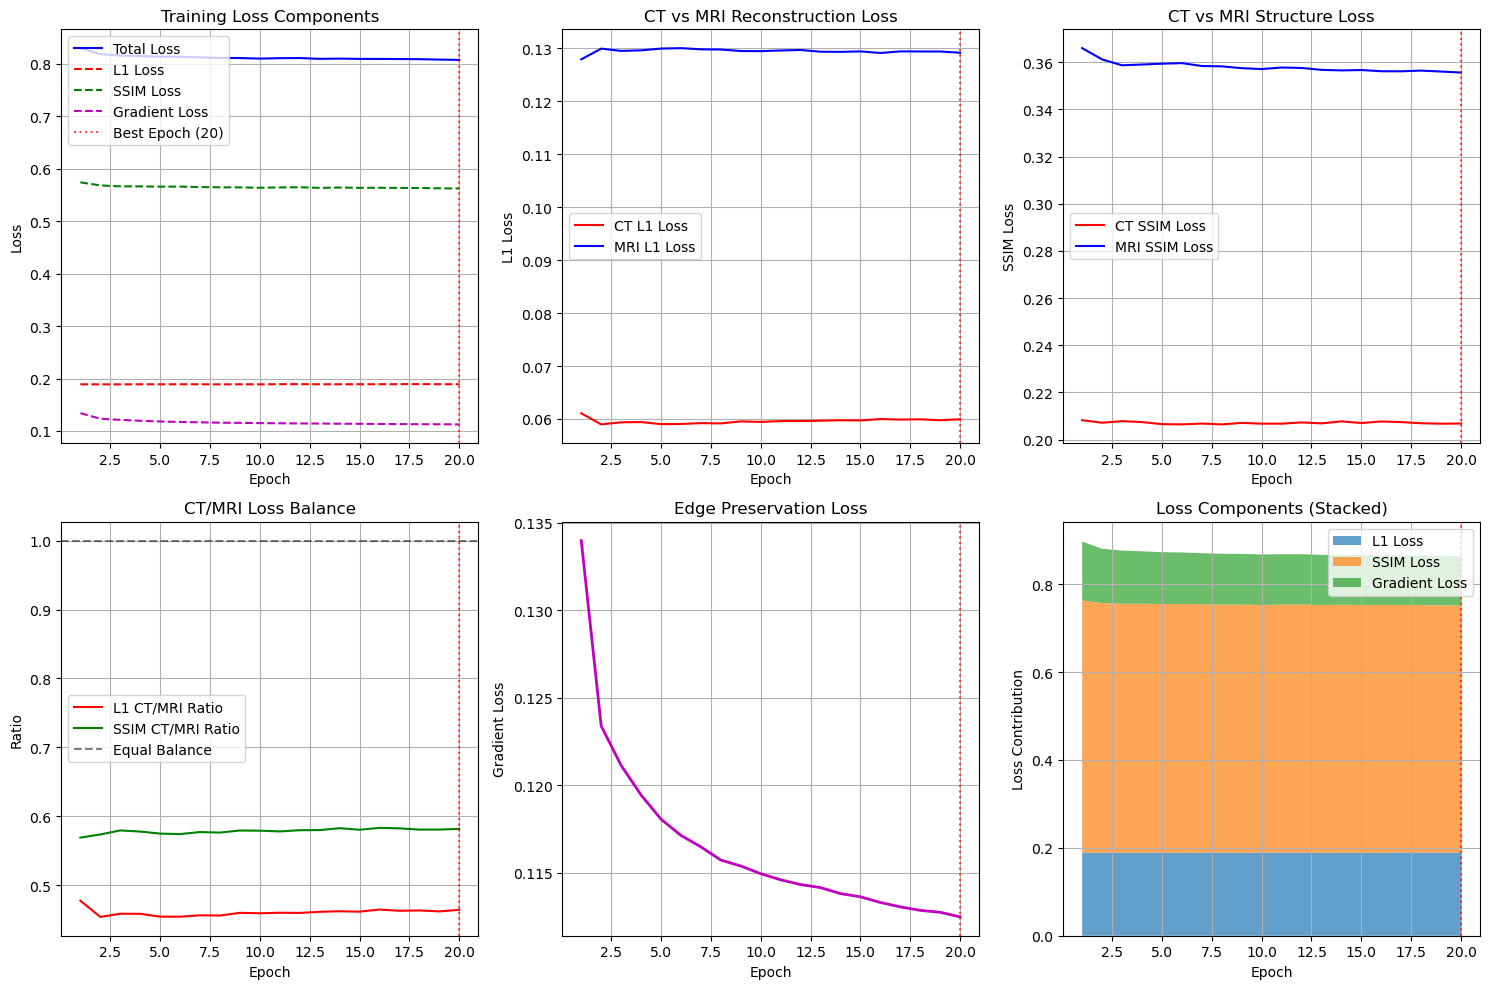


Final Training Metrics:
  total: 0.8078
  l1: 0.1891
  ssim: 0.5625
  gradient: 0.1125
  l1_ct: 0.0600
  l1_mr: 0.1291
  ssim_ct: 0.2068
  ssim_mr: 0.3556

Model checkpoints saved in 'checkpoints/' directory:
  - Best model: wavelet_fusion_spatial_best.pt
  - Final model: wavelet_fusion_spatial_final.pt
  - Training history: training_history.pt
  - Latest epoch checkpoints: wavelet_fusion_spatial_epoch_X.pt


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset
dataset = CTMRIDataset('../Dataset/CT-MRI/CT','../Dataset/CT-MRI/MRI')
loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Model, enhanced loss, optimizer
model = WaveletFusionNetSpatial().to(device)
criterion = EnhancedFusionLoss(w_l1=1.0, w_ssim=1.0, w_grad=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Create checkpoints directory for option 2
os.makedirs('checkpoints/intermediate/trainable_wavelet_fusion', exist_ok=True)
os.makedirs('checkpoints/final/trainable_wavelet_fusion', exist_ok=True)

# Training with comprehensive error tracking and model saving
epochs = 20  # Increased for better training
epoch_metrics = []
best_loss = float('inf')
best_epoch = 0

print("Starting Enhanced Training with Comprehensive Error Metrics")
print("=" * 70)

for ep in range(epochs):
    model.train()
    epoch_losses = {
        'total': [],
        'l1': [],
        'ssim': [],
        'gradient': [],
        'l1_ct': [],
        'l1_mr': [],
        'ssim_ct': [],
        'ssim_mr': []
    }
    
    print(f"\nEpoch [{ep+1}/{epochs}]")
    print("-" * 50)
    
    for i, (ct, mr) in enumerate(loader):
        ct, mr = ct.to(device), mr.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        fused = model(ct, mr)
        
        # Calculate enhanced loss
        loss, loss_dict = criterion(fused, ct, mr)
        
        # Store losses
        for key, value in loss_dict.items():
            epoch_losses[key].append(value.item())
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Print detailed metrics every 5 steps
        if i % 5 == 0:
            print(f"Step [{i:3d}/{len(loader)}] | "
                  f"Total: {loss.item():.4f} | "
                  f"L1: {loss_dict['l1'].item():.4f} | "
                  f"SSIM: {loss_dict['ssim'].item():.4f} | "
                  f"Grad: {loss_dict['gradient'].item():.4f}")
    
    # Calculate epoch averages
    epoch_avg = {key: np.mean(values) for key, values in epoch_losses.items()}
    epoch_metrics.append(epoch_avg)
    
    print(f"\nEpoch {ep+1} Summary:")
    print(f"  Average Total Loss: {epoch_avg['total']:.4f}")
    print(f"  Average L1 Loss: {epoch_avg['l1']:.4f}")
    print(f"  Average SSIM Loss: {epoch_avg['ssim']:.4f}")
    print(f"  Average Gradient Loss: {epoch_avg['gradient']:.4f}")
    print(f"  CT Reconstruction (L1): {epoch_avg['l1_ct']:.4f}")
    print(f"  MRI Reconstruction (L1): {epoch_avg['l1_mr']:.4f}")
    print(f"  CT Structure (SSIM): {epoch_avg['ssim_ct']:.4f}")
    print(f"  MRI Structure (SSIM): {epoch_avg['ssim_mr']:.4f}")
    
    # Save best model
    current_loss = epoch_avg['total']
    if current_loss < best_loss:
        best_loss = current_loss
        best_epoch = ep + 1
        
        # Save the best model
        checkpoint = {
            'epoch': ep + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_loss': best_loss,
            'epoch_metrics': epoch_metrics,
            'model_config': {
                'model_type': 'WaveletFusionNetSpatial',
                'wave': 'haar',
                'loss_weights': {'w_l1': 1.0, 'w_ssim': 1.0, 'w_grad': 0.5}
            }
        }
        
        torch.save(checkpoint, 'checkpoints/final/trainable_wavelet_fusion/wavelet_fusion_spatial_best.pt')
        print(f"  ✅ New best model saved! (Loss: {best_loss:.4f})")
    
    # Save latest model every 5 epochs
    if (ep + 1) % 5 == 0:
        checkpoint = {
            'epoch': ep + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'current_loss': current_loss,
            'epoch_metrics': epoch_metrics,
            'model_config': {
                'model_type': 'WaveletFusionNetSpatial',
                'wave': 'haar',
                'loss_weights': {'w_l1': 1.0, 'w_ssim': 1.0, 'w_grad': 0.5}
            }
        }
        torch.save(checkpoint, f'checkpoints/intermediate/trainable_wavelet_fusion/wavelet_fusion_spatial_epoch_{ep+1}.pt')
        print(f"  💾 Checkpoint saved at epoch {ep+1}")

print("\n" + "=" * 70)
print("Training Complete!")
print(f"Best model achieved at epoch {best_epoch} with loss: {best_loss:.4f}")
print(f"Best model saved to: checkpoints/final/trainable_wavelet_fusion/wavelet_fusion_spatial_best.pt")

# Save final model state as well (in case best wasn't the last)
final_checkpoint = {
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_loss': epoch_metrics[-1]['total'] if epoch_metrics else current_loss,
    'best_loss': best_loss,
    'best_epoch': best_epoch,
    'epoch_metrics': epoch_metrics,
    'model_config': {
        'model_type': 'WaveletFusionNetSpatial',
        'wave': 'haar',
        'loss_weights': {'w_l1': 1.0, 'w_ssim': 1.0, 'w_grad': 0.5}
    }
}
torch.save(final_checkpoint, 'checkpoints/final/trainable_wavelet_fusion/wavelet_fusion_spatial_final.pt')
print(f"📁 Final model state saved to: checkpoints/final/trainable_wavelet_fusion/wavelet_fusion_spatial_final.pt")

# Plot training curves
plt.figure(figsize=(15, 10))

# Plot main losses
plt.subplot(2, 3, 1)
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, [m['total'] for m in epoch_metrics], 'b-', label='Total Loss')
plt.plot(epochs_range, [m['l1'] for m in epoch_metrics], 'r--', label='L1 Loss')
plt.plot(epochs_range, [m['ssim'] for m in epoch_metrics], 'g--', label='SSIM Loss')
plt.plot(epochs_range, [m['gradient'] for m in epoch_metrics], 'm--', label='Gradient Loss')
# Mark best epoch
plt.axvline(x=best_epoch, color='red', linestyle=':', alpha=0.7, label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Components')
plt.legend()
plt.grid(True)

# Plot CT vs MRI L1 losses
plt.subplot(2, 3, 2)
plt.plot(epochs_range, [m['l1_ct'] for m in epoch_metrics], 'r-', label='CT L1 Loss')
plt.plot(epochs_range, [m['l1_mr'] for m in epoch_metrics], 'b-', label='MRI L1 Loss')
plt.axvline(x=best_epoch, color='red', linestyle=':', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('CT vs MRI Reconstruction Loss')
plt.legend()
plt.grid(True)

# Plot CT vs MRI SSIM losses
plt.subplot(2, 3, 3)
plt.plot(epochs_range, [m['ssim_ct'] for m in epoch_metrics], 'r-', label='CT SSIM Loss')
plt.plot(epochs_range, [m['ssim_mr'] for m in epoch_metrics], 'b-', label='MRI SSIM Loss')
plt.axvline(x=best_epoch, color='red', linestyle=':', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('SSIM Loss')
plt.title('CT vs MRI Structure Loss')
plt.legend()
plt.grid(True)

# Plot loss ratios
plt.subplot(2, 3, 4)
l1_ratios = [m['l1_ct'] / (m['l1_mr'] + 1e-8) for m in epoch_metrics]
ssim_ratios = [m['ssim_ct'] / (m['ssim_mr'] + 1e-8) for m in epoch_metrics]
plt.plot(epochs_range, l1_ratios, 'r-', label='L1 CT/MRI Ratio')
plt.plot(epochs_range, ssim_ratios, 'g-', label='SSIM CT/MRI Ratio')
plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Equal Balance')
plt.axvline(x=best_epoch, color='red', linestyle=':', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Ratio')
plt.title('CT/MRI Loss Balance')
plt.legend()
plt.grid(True)

# Plot gradient loss evolution
plt.subplot(2, 3, 5)
plt.plot(epochs_range, [m['gradient'] for m in epoch_metrics], 'm-', linewidth=2)
plt.axvline(x=best_epoch, color='red', linestyle=':', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Gradient Loss')
plt.title('Edge Preservation Loss')
plt.grid(True)

# Plot total loss with components stacked
plt.subplot(2, 3, 6)
l1_vals = [m['l1'] for m in epoch_metrics]
ssim_vals = [m['ssim'] for m in epoch_metrics]
grad_vals = [m['gradient'] for m in epoch_metrics]

plt.stackplot(epochs_range, l1_vals, ssim_vals, grad_vals, 
              labels=['L1 Loss', 'SSIM Loss', 'Gradient Loss'],
              alpha=0.7)
plt.axvline(x=best_epoch, color='red', linestyle=':', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss Contribution')
plt.title('Loss Components (Stacked)')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Save training metrics
training_history = {
    'epoch_metrics': epoch_metrics,
    'loss_components': ['total', 'l1', 'ssim', 'gradient', 'l1_ct', 'l1_mr', 'ssim_ct', 'ssim_mr'],
    'best_epoch': best_epoch,
    'best_loss': best_loss,
    'final_loss': epoch_metrics[-1]['total'] if epoch_metrics else None
}

# Save training history
torch.save(training_history, 'checkpoints/final/trainable_wavelet_fusion/training_history.pt')

print("\nFinal Training Metrics:")
final_metrics = epoch_metrics[-1]
for key, value in final_metrics.items():
    print(f"  {key}: {value:.4f}")

print(f"\nModel checkpoints saved in 'checkpoints/' directory:")
print(f"  - Best model: wavelet_fusion_spatial_best.pt")
print(f"  - Final model: wavelet_fusion_spatial_final.pt")
print(f"  - Training history: training_history.pt")
print(f"  - Latest epoch checkpoints: wavelet_fusion_spatial_epoch_X.pt")

COMPREHENSIVE FUSION QUALITY EVALUATION

Image Information:
  CT range: [0.000, 1.000]
  MRI range: [0.000, 0.788]
  Fused range: [-0.076, 1.001]
  Image shape: (256, 256)

-------------------Fusion Quality Metrics-------------------

Structural Similarity (SSIM):
  SSIM with CT:     0.7569
  SSIM with MRI:    0.6948
  Average SSIM:     0.7259

Peak Signal-to-Noise Ratio (PSNR):
  PSNR with CT:     18.25 dB
  PSNR with MRI:    10.54 dB
  Average PSNR:     14.40 dB

Edge and Information Metrics:
  Edge Preservation: 0.8460
  Entropy:          4.2740 bits

Mutual Information:
  MI with CT:       1.2131 bits
  MI with MRI:      1.4454 bits
  Average MI:       1.3292 bits

---------------------Quality Assessment---------------------
  Structural Quality (SSIM):     Good
  Noise Level (PSNR):           Poor
  Edge Preservation:            Good
  Overall Quality Score:        0.688 (Fair)


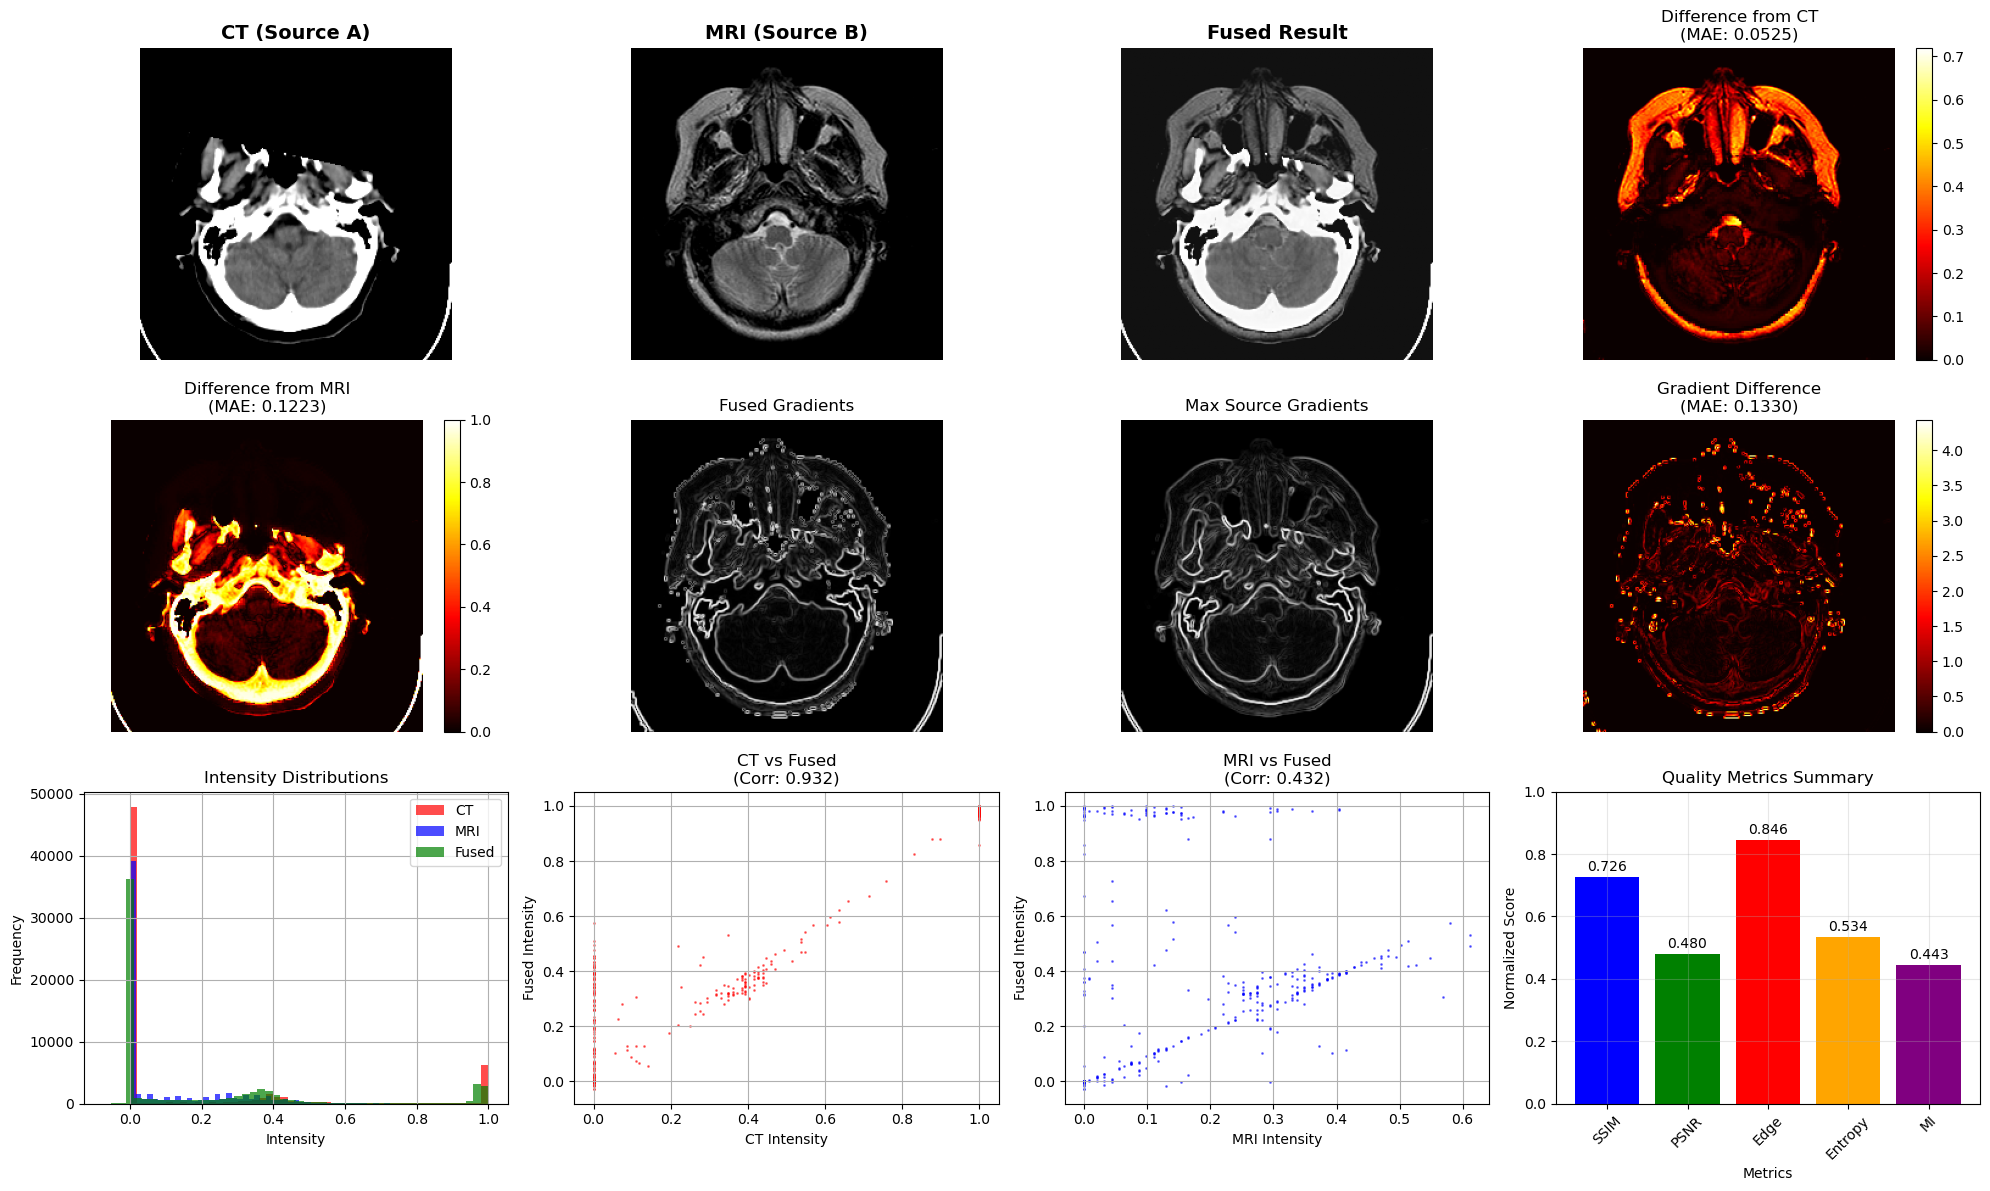


EVALUATION COMPLETE


In [13]:
# Comprehensive Evaluation with Error Metrics
print("=" * 80)
print("COMPREHENSIVE FUSION QUALITY EVALUATION")
print("=" * 80)

model.eval()
with torch.no_grad():
    # Get test sample
    ct, mr = dataset[0]
    ct_orig, mr_orig = ct.squeeze().numpy(), mr.squeeze().numpy()
    ct, mr = ct.unsqueeze(0).to(device), mr.unsqueeze(0).to(device)
    
    # Generate fusion
    fused = model(ct, mr)
    fused_img = fused.squeeze().cpu().numpy()
    
    print(f"\nImage Information:")
    print(f"  CT range: [{ct_orig.min():.3f}, {ct_orig.max():.3f}]")
    print(f"  MRI range: [{mr_orig.min():.3f}, {mr_orig.max():.3f}]")
    print(f"  Fused range: [{fused_img.min():.3f}, {fused_img.max():.3f}]")
    print(f"  Image shape: {fused_img.shape}")
    
    # Calculate comprehensive metrics
    print(f"\n" + "Fusion Quality Metrics".center(60, "-"))
    metrics = evaluate_fusion_quality(fused_img, ct_orig, mr_orig)
    
    print(f"\nStructural Similarity (SSIM):")
    print(f"  SSIM with CT:     {metrics['SSIM_CT']:.4f}")
    print(f"  SSIM with MRI:    {metrics['SSIM_MRI']:.4f}")
    print(f"  Average SSIM:     {metrics['SSIM_Avg']:.4f}")
    
    print(f"\nPeak Signal-to-Noise Ratio (PSNR):")
    print(f"  PSNR with CT:     {metrics['PSNR_CT']:.2f} dB")
    print(f"  PSNR with MRI:    {metrics['PSNR_MRI']:.2f} dB")
    print(f"  Average PSNR:     {metrics['PSNR_Avg']:.2f} dB")
    
    print(f"\nEdge and Information Metrics:")
    print(f"  Edge Preservation: {metrics['Edge_Preservation']:.4f}")
    print(f"  Entropy:          {metrics['Entropy']:.4f} bits")
    
    print(f"\nMutual Information:")
    print(f"  MI with CT:       {metrics['MI_CT']:.4f} bits")
    print(f"  MI with MRI:      {metrics['MI_MRI']:.4f} bits")
    print(f"  Average MI:       {metrics['MI_Avg']:.4f} bits")
    
    # Quality assessment
    print(f"\n" + "Quality Assessment".center(60, "-"))
    
    # SSIM quality levels
    avg_ssim = metrics['SSIM_Avg']
    if avg_ssim >= 0.8:
        ssim_quality = "Excellent"
    elif avg_ssim >= 0.7:
        ssim_quality = "Good"
    elif avg_ssim >= 0.6:
        ssim_quality = "Fair"
    else:
        ssim_quality = "Poor"
    
    # PSNR quality levels
    avg_psnr = metrics['PSNR_Avg']
    if avg_psnr >= 30:
        psnr_quality = "Excellent"
    elif avg_psnr >= 25:
        psnr_quality = "Good"
    elif avg_psnr >= 20:
        psnr_quality = "Fair"
    else:
        psnr_quality = "Poor"
    
    # Edge preservation quality
    edge_pres = metrics['Edge_Preservation']
    if edge_pres >= 0.9:
        edge_quality = "Excellent"
    elif edge_pres >= 0.8:
        edge_quality = "Good"
    elif edge_pres >= 0.7:
        edge_quality = "Fair"
    else:
        edge_quality = "Poor"
    
    print(f"  Structural Quality (SSIM):     {ssim_quality}")
    print(f"  Noise Level (PSNR):           {psnr_quality}")
    print(f"  Edge Preservation:            {edge_quality}")
    
    # Overall quality score (weighted combination)
    quality_score = (0.4 * metrics['SSIM_Avg'] + 
                    0.3 * min(metrics['PSNR_Avg']/30, 1.0) + 
                    0.3 * metrics['Edge_Preservation'])
    
    if quality_score >= 0.8:
        overall_quality = "Excellent"
    elif quality_score >= 0.7:
        overall_quality = "Good"
    elif quality_score >= 0.6:
        overall_quality = "Fair"
    else:
        overall_quality = "Poor"
    
    print(f"  Overall Quality Score:        {quality_score:.3f} ({overall_quality})")

# Enhanced Visualization with Error Analysis
plt.figure(figsize=(20, 12))

# Original images and fusion result
plt.subplot(3, 4, 1)
plt.imshow(ct_orig, cmap='gray')
plt.title('CT (Source A)', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(mr_orig, cmap='gray')
plt.title('MRI (Source B)', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(fused_img, cmap='gray')
plt.title('Fused Result', fontsize=14, fontweight='bold')
plt.axis('off')

# Difference maps
plt.subplot(3, 4, 4)
diff_ct = np.abs(fused_img - ct_orig)
plt.imshow(diff_ct, cmap='hot')
plt.title(f'Difference from CT\n(MAE: {np.mean(diff_ct):.4f})', fontsize=12)
plt.colorbar()
plt.axis('off')

plt.subplot(3, 4, 5)
diff_mr = np.abs(fused_img - mr_orig)
plt.imshow(diff_mr, cmap='hot')
plt.title(f'Difference from MRI\n(MAE: {np.mean(diff_mr):.4f})', fontsize=12)
plt.colorbar()
plt.axis('off')

# Gradient analysis
plt.subplot(3, 4, 6)
grad_fused = calculate_gradient_magnitude(fused_img)
plt.imshow(grad_fused, cmap='gray')
plt.title('Fused Gradients', fontsize=12)
plt.axis('off')

plt.subplot(3, 4, 7)
grad_ct = calculate_gradient_magnitude(ct_orig)
grad_mr = calculate_gradient_magnitude(mr_orig)
grad_max = np.maximum(grad_ct, grad_mr)
plt.imshow(grad_max, cmap='gray')
plt.title('Max Source Gradients', fontsize=12)
plt.axis('off')

plt.subplot(3, 4, 8)
grad_diff = np.abs(grad_fused - grad_max)
plt.imshow(grad_diff, cmap='hot')
plt.title(f'Gradient Difference\n(MAE: {np.mean(grad_diff):.4f})', fontsize=12)
plt.colorbar()
plt.axis('off')

# Histograms
plt.subplot(3, 4, 9)
plt.hist(ct_orig.flatten(), bins=50, alpha=0.7, label='CT', color='red')
plt.hist(mr_orig.flatten(), bins=50, alpha=0.7, label='MRI', color='blue')
plt.hist(fused_img.flatten(), bins=50, alpha=0.7, label='Fused', color='green')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Intensity Distributions')
plt.legend()
plt.grid(True)

# Cross-correlation analysis
plt.subplot(3, 4, 10)
plt.scatter(ct_orig.flatten()[::100], fused_img.flatten()[::100], alpha=0.5, s=1, color='red')
plt.xlabel('CT Intensity')
plt.ylabel('Fused Intensity')
plt.title(f'CT vs Fused\n(Corr: {np.corrcoef(ct_orig.flatten(), fused_img.flatten())[0,1]:.3f})')
plt.grid(True)

plt.subplot(3, 4, 11)
plt.scatter(mr_orig.flatten()[::100], fused_img.flatten()[::100], alpha=0.5, s=1, color='blue')
plt.xlabel('MRI Intensity')
plt.ylabel('Fused Intensity')
plt.title(f'MRI vs Fused\n(Corr: {np.corrcoef(mr_orig.flatten(), fused_img.flatten())[0,1]:.3f})')
plt.grid(True)

# Summary metrics visualization
plt.subplot(3, 4, 12)
metrics_names = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Pres', 'Entropy', 'MI_Avg']
metrics_values = [metrics['SSIM_Avg'], 
                 metrics['PSNR_Avg']/30,  # Normalize PSNR
                 metrics['Edge_Preservation'], 
                 metrics['Entropy']/8,  # Normalize entropy
                 metrics['MI_Avg']/3]   # Normalize MI

bars = plt.bar(range(len(metrics_names)), metrics_values, 
               color=['blue', 'green', 'red', 'orange', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Normalized Score')
plt.title('Quality Metrics Summary')
plt.xticks(range(len(metrics_names)), 
           ['SSIM', 'PSNR', 'Edge', 'Entropy', 'MI'], rotation=45)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n" + "=" * 80)
print("EVALUATION COMPLETE")
print("=" * 80)

COMPARATIVE ANALYSIS: TRAINED MODEL vs BASELINE METHODS
Testing 5 image pairs...

Test Image 1:
----------------------------------------
  Trained Model  : SSIM=0.726, PSNR=14.4dB, Edge=0.846, Entropy=4.27
  Average        : SSIM=0.670, PSNR=15.6dB, Edge=0.972, Entropy=4.14
  Maximum        : SSIM=0.717, PSNR=13.8dB, Edge=0.960, Entropy=3.43
  Weighted (0.6) : SSIM=0.667, PSNR=15.7dB, Edge=0.975, Entropy=4.14

Test Image 2:
----------------------------------------
  Trained Model  : SSIM=0.727, PSNR=14.0dB, Edge=0.834, Entropy=4.44
  Average        : SSIM=0.680, PSNR=15.2dB, Edge=0.972, Entropy=4.34
  Average        : SSIM=0.680, PSNR=15.2dB, Edge=0.972, Entropy=4.34
  Maximum        : SSIM=0.716, PSNR=13.4dB, Edge=0.945, Entropy=3.50
  Weighted (0.6) : SSIM=0.676, PSNR=15.4dB, Edge=0.974, Entropy=4.34

Test Image 3:
----------------------------------------
  Trained Model  : SSIM=0.724, PSNR=13.7dB, Edge=0.842, Entropy=4.41
  Average        : SSIM=0.678, PSNR=14.6dB, Edge=0.970, Entro

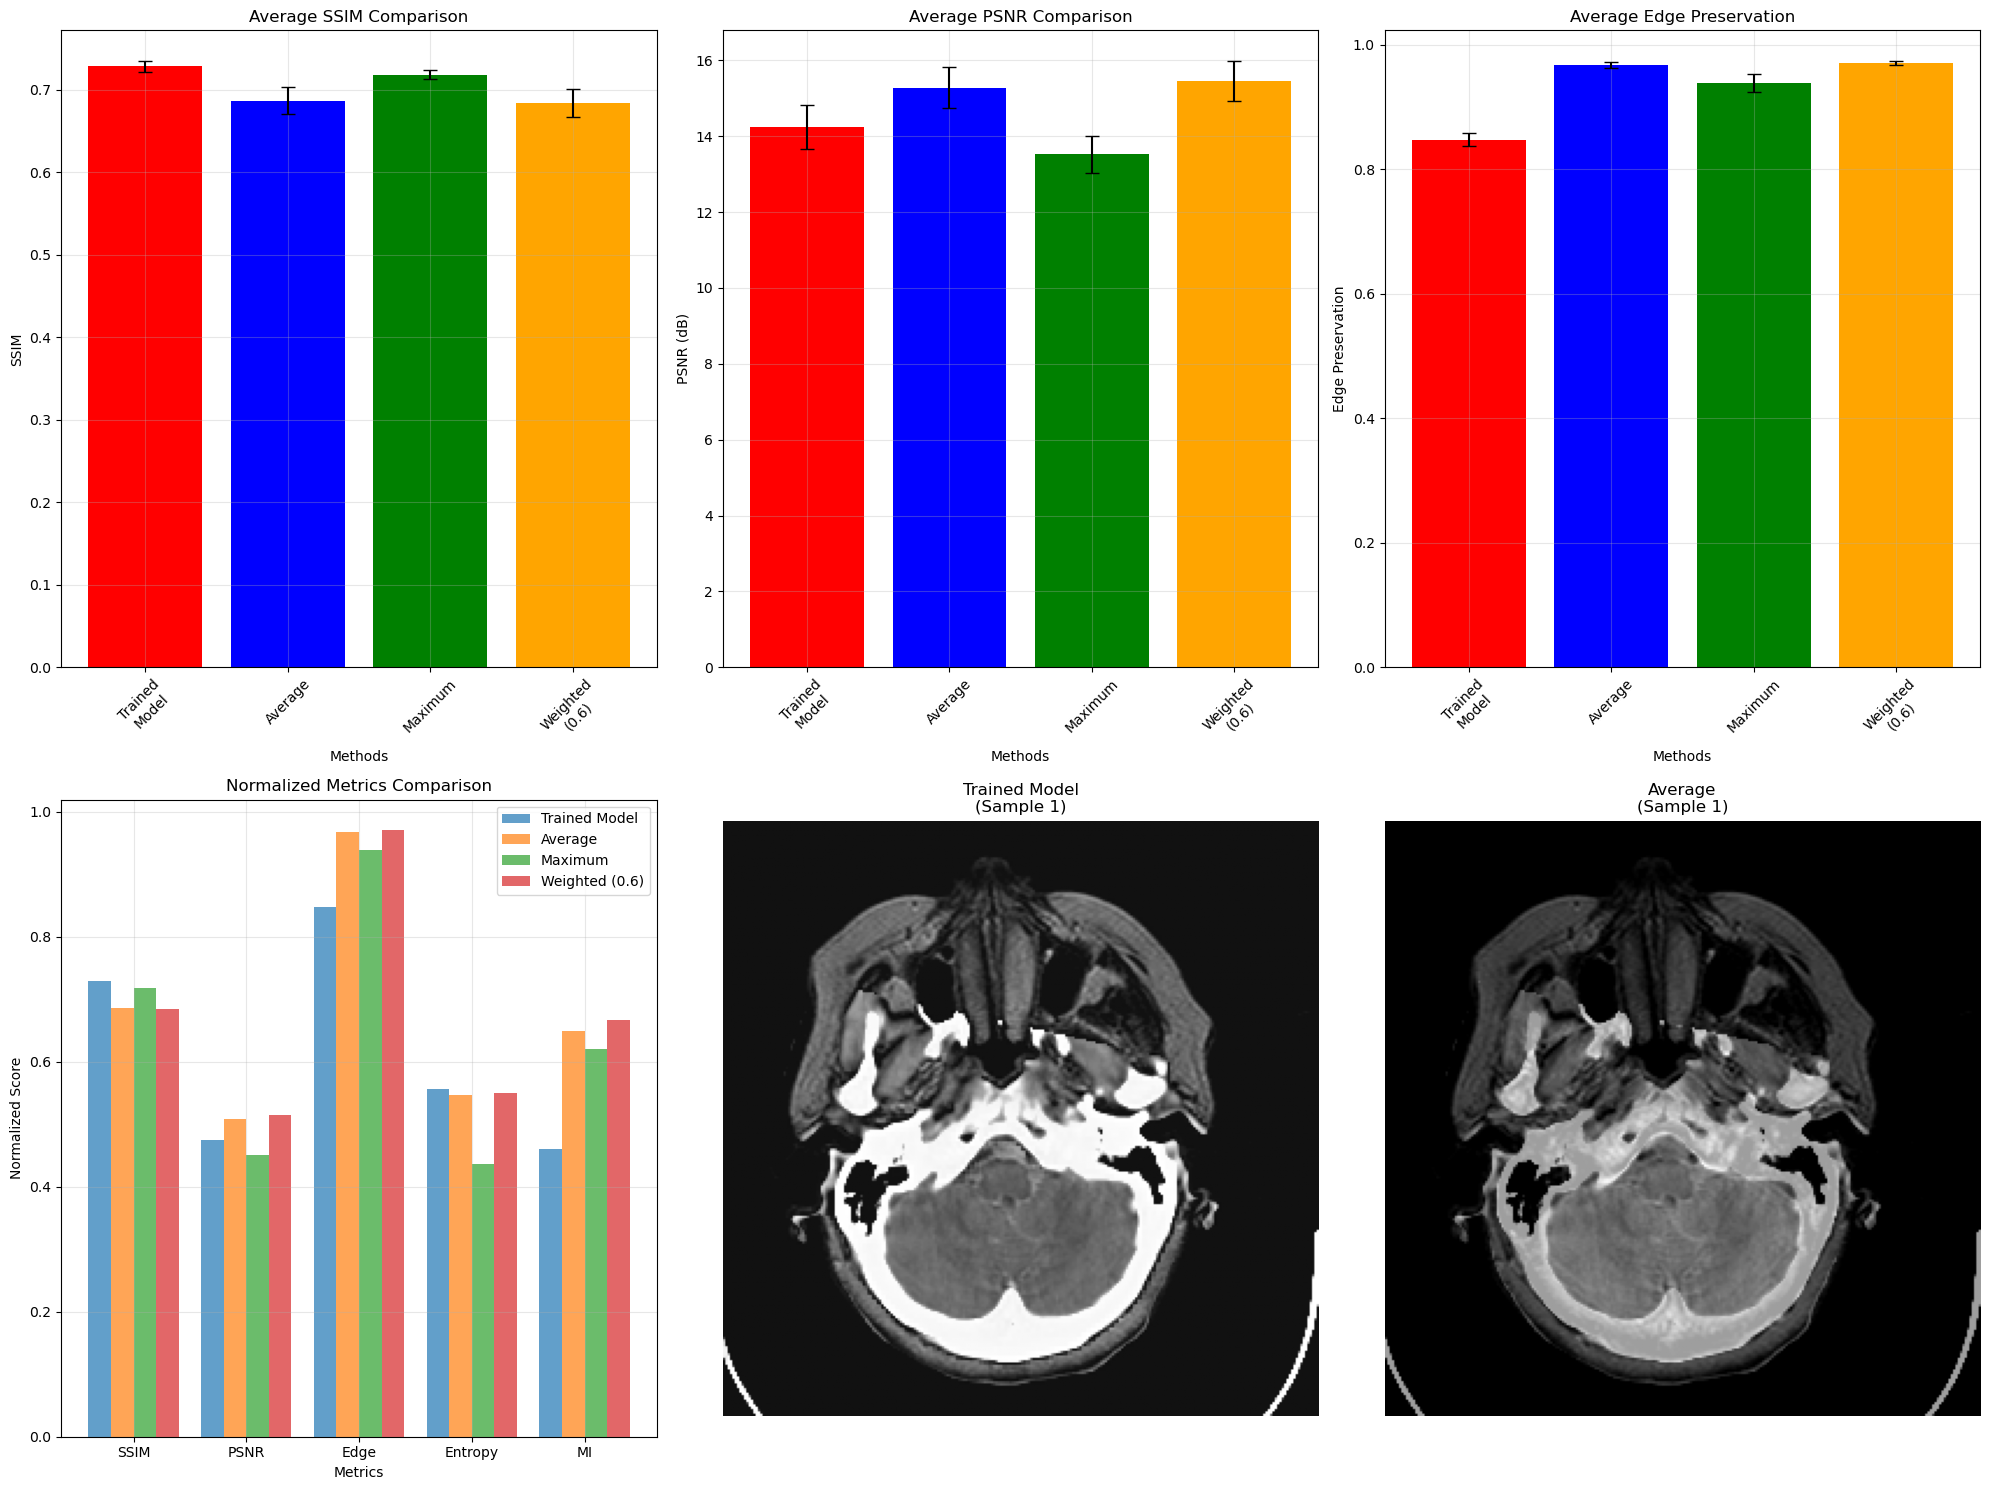


==============================FINAL SUMMARY REPORT==============================

Training Configuration:
  Epochs: 20
  Loss Components: L1 + SSIM + Gradient
  Final Training Loss: 0.8078

Best Performing Method per Metric:
  SSIM_Avg            : Trained Model (0.728)
  PSNR_Avg            : Weighted (0.6) (15.451)
  Edge_Preservation   : Weighted (0.6) (0.971)
  Entropy             : Trained Model (4.451)
  MI_Avg              : Weighted (0.6) (2.001)

Overall Best Method: Weighted (0.6) (Score: 0.698)

ANALYSIS COMPLETE


In [14]:
# Comprehensive Comparison of Fusion Methods
print("=" * 90)
print("COMPARATIVE ANALYSIS: TRAINED MODEL vs BASELINE METHODS")
print("=" * 90)

def fuse_average(ct, mri):
    """Simple average fusion."""
    return 0.5 * (ct + mri)

def fuse_maximum(ct, mri):
    """Maximum-based fusion."""
    return np.maximum(ct, mri)

def fuse_weighted(ct, mri, weight=0.6):
    """Weighted fusion favoring CT."""
    return weight * ct + (1 - weight) * mri

def fuse_with_model(model, ct, mri):
    """Fuse using trained model."""
    model.eval()
    with torch.no_grad():
        ct_tensor = torch.from_numpy(ct)[None, None, ...].to(device)
        mri_tensor = torch.from_numpy(mri)[None, None, ...].to(device)
        fused_tensor = model(ct_tensor, mri_tensor)
        return fused_tensor.squeeze().cpu().numpy()

# Test multiple image pairs
test_results = []
num_test_images = min(5, len(dataset))

print(f"Testing {num_test_images} image pairs...\n")

for test_idx in range(num_test_images):
    ct, mr = dataset[test_idx]
    ct_img, mr_img = ct.squeeze().numpy(), mr.squeeze().numpy()
    
    print(f"Test Image {test_idx + 1}:")
    print("-" * 40)
    
    # Different fusion methods
    fusion_methods = {
        'Trained Model': fuse_with_model(model, ct_img, mr_img),
        'Average': fuse_average(ct_img, mr_img),
        'Maximum': fuse_maximum(ct_img, mr_img),
        'Weighted (0.6)': fuse_weighted(ct_img, mr_img, 0.6)
    }
    
    # Evaluate each method
    method_results = {}
    for method_name, fused_img in fusion_methods.items():
        metrics = evaluate_fusion_quality(fused_img, ct_img, mr_img)
        method_results[method_name] = metrics
        
        print(f"  {method_name:15s}: SSIM={metrics['SSIM_Avg']:.3f}, "
              f"PSNR={metrics['PSNR_Avg']:.1f}dB, "
              f"Edge={metrics['Edge_Preservation']:.3f}, "
              f"Entropy={metrics['Entropy']:.2f}")
    
    test_results.append({
        'image_idx': test_idx,
        'methods': method_results,
        'ct_img': ct_img,
        'mr_img': mr_img,
        'fusion_results': fusion_methods
    })
    print()

# Aggregate statistics
print("AGGREGATE PERFORMANCE STATISTICS")
print("=" * 50)

metrics_names = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg']
method_names = list(test_results[0]['methods'].keys())

aggregate_stats = {}
for method in method_names:
    aggregate_stats[method] = {}
    for metric in metrics_names:
        values = [result['methods'][method][metric] for result in test_results]
        aggregate_stats[method][metric] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values)
        }

# Display aggregate statistics
for method in method_names:
    print(f"\n{method}:")
    print(f"  SSIM:      {aggregate_stats[method]['SSIM_Avg']['mean']:.3f} ± {aggregate_stats[method]['SSIM_Avg']['std']:.3f}")
    print(f"  PSNR:      {aggregate_stats[method]['PSNR_Avg']['mean']:.1f} ± {aggregate_stats[method]['PSNR_Avg']['std']:.1f} dB")
    print(f"  Edge Pres: {aggregate_stats[method]['Edge_Preservation']['mean']:.3f} ± {aggregate_stats[method]['Edge_Preservation']['std']:.3f}")
    print(f"  Entropy:   {aggregate_stats[method]['Entropy']['mean']:.2f} ± {aggregate_stats[method]['Entropy']['std']:.2f} bits")
    print(f"  MI:        {aggregate_stats[method]['MI_Avg']['mean']:.3f} ± {aggregate_stats[method]['MI_Avg']['std']:.3f} bits")

# Performance ranking
print(f"\nPERFORMANCE RANKING")
print("=" * 30)

ranking_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg']
for metric in ranking_metrics:
    print(f"\nBest {metric}:")
    sorted_methods = sorted(method_names, 
                           key=lambda x: aggregate_stats[x][metric]['mean'], 
                           reverse=(metric in ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg']))
    for i, method in enumerate(sorted_methods, 1):
        value = aggregate_stats[method][metric]['mean']
        print(f"  {i}. {method:15s}: {value:.3f}")

# Visualization of comparative results
plt.figure(figsize=(20, 15))

# Performance comparison radar chart style
metrics_for_radar = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg']
normalized_stats = {}

for method in method_names:
    normalized_stats[method] = []
    for metric in metrics_for_radar:
        value = aggregate_stats[method][metric]['mean']
        if metric == 'PSNR_Avg':
            normalized_value = min(value / 30, 1.0)  # Normalize PSNR
        elif metric == 'Entropy':
            normalized_value = min(value / 8, 1.0)   # Normalize Entropy
        elif metric == 'MI_Avg':
            normalized_value = min(value / 3, 1.0)   # Normalize MI
        else:
            normalized_value = value  # SSIM and Edge Preservation already [0,1]
        normalized_stats[method].append(normalized_value)

# Bar chart comparison
plt.subplot(2, 3, 1)
x_pos = np.arange(len(method_names))
ssim_means = [aggregate_stats[method]['SSIM_Avg']['mean'] for method in method_names]
ssim_stds = [aggregate_stats[method]['SSIM_Avg']['std'] for method in method_names]
bars = plt.bar(x_pos, ssim_means, yerr=ssim_stds, capsize=5, 
               color=['red', 'blue', 'green', 'orange'])
plt.xlabel('Methods')
plt.ylabel('SSIM')
plt.title('Average SSIM Comparison')
plt.xticks(x_pos, [m.replace(' ', '\n') for m in method_names], rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
psnr_means = [aggregate_stats[method]['PSNR_Avg']['mean'] for method in method_names]
psnr_stds = [aggregate_stats[method]['PSNR_Avg']['std'] for method in method_names]
bars = plt.bar(x_pos, psnr_means, yerr=psnr_stds, capsize=5,
               color=['red', 'blue', 'green', 'orange'])
plt.xlabel('Methods')
plt.ylabel('PSNR (dB)')
plt.title('Average PSNR Comparison')
plt.xticks(x_pos, [m.replace(' ', '\n') for m in method_names], rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
edge_means = [aggregate_stats[method]['Edge_Preservation']['mean'] for method in method_names]
edge_stds = [aggregate_stats[method]['Edge_Preservation']['std'] for method in method_names]
bars = plt.bar(x_pos, edge_means, yerr=edge_stds, capsize=5,
               color=['red', 'blue', 'green', 'orange'])
plt.xlabel('Methods')
plt.ylabel('Edge Preservation')
plt.title('Average Edge Preservation')
plt.xticks(x_pos, [m.replace(' ', '\n') for m in method_names], rotation=45)
plt.grid(True, alpha=0.3)

# Normalized metrics comparison
plt.subplot(2, 3, 4)
width = 0.2
for i, method in enumerate(method_names):
    plt.bar(np.arange(len(metrics_for_radar)) + i*width, normalized_stats[method], 
            width, label=method, alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Normalized Score')
plt.title('Normalized Metrics Comparison')
plt.xticks(np.arange(len(metrics_for_radar)) + width*1.5, 
           ['SSIM', 'PSNR', 'Edge', 'Entropy', 'MI'])
plt.legend()
plt.grid(True, alpha=0.3)

# Sample fusion results visualization
plt.subplot(2, 3, 5)
sample_idx = 0
sample_result = test_results[sample_idx]
methods_to_show = ['Trained Model', 'Average']
for i, method in enumerate(methods_to_show):
    fused = sample_result['fusion_results'][method]
    plt.subplot(2, 3, 5 + i)
    plt.imshow(fused, cmap='gray')
    plt.title(f'{method}\n(Sample {sample_idx + 1})')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Summary report
print(f"\n" + "FINAL SUMMARY REPORT".center(80, "="))
print(f"\nTraining Configuration:")
print(f"  Epochs: {epochs}")
print(f"  Loss Components: L1 + SSIM + Gradient")
print(f"  Final Training Loss: {epoch_metrics[-1]['total']:.4f}")

print(f"\nBest Performing Method per Metric:")
best_methods = {}
for metric in metrics_names:
    best_method = max(method_names, key=lambda x: aggregate_stats[x][metric]['mean'])
    best_value = aggregate_stats[best_method][metric]['mean']
    best_methods[metric] = (best_method, best_value)
    print(f"  {metric:20s}: {best_method} ({best_value:.3f})")

# Calculate overall winner
overall_scores = {}
for method in method_names:
    score = (0.3 * aggregate_stats[method]['SSIM_Avg']['mean'] +
             0.25 * min(aggregate_stats[method]['PSNR_Avg']['mean']/30, 1.0) +
             0.25 * aggregate_stats[method]['Edge_Preservation']['mean'] +
             0.1 * min(aggregate_stats[method]['Entropy']['mean']/8, 1.0) +
             0.1 * min(aggregate_stats[method]['MI_Avg']['mean']/3, 1.0))
    overall_scores[method] = score

best_overall = max(overall_scores, key=overall_scores.get)
print(f"\nOverall Best Method: {best_overall} (Score: {overall_scores[best_overall]:.3f})")

print(f"\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)